# 2019 Canadian Election Twitter Analytics
## Sam Weinberg (sam.weinberg@mail.utoronto.ca)
## 05/04/2020

This notebook uses NLP to analyze tweets pertaining to the 2019 Canadian Election. The goal was to determine if analyzing twitter data could provide insight on the 2019 political landscape. We work with two dataset: one containing political tweets and one containing generic tweets. We will use the generic tweets to build our model, and perform sentiment analysis on the political tweets. This notebook was an excellent experience to work with textual data and popular NLP libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import html
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
try:
    import emoji #If tweepy is already installed on the system
except:
    !pip install emoji

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read in tweets as pandas dataframe
df = pd.read_csv('Canadian_elections_2019.csv')
df2 = pd.read_csv('Sentiment.csv')

In [3]:
# Visualize canadian election tweets
df.text

0       b"@RosieBarton So instead of your suggestion, ...
1       b"#AllWomanSpacewalk it's real!\n@Space_Statio...
2       b"#Brantford It's going to cost YOU $94 BILLIO...
3       b"#Canada #CanadaElection2019 #CanadaVotes \n#...
4       b"#Canada #taxpayers are sick &amp; tired of h...
5       b"#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...
6       b"#CDNmedia #elxn43 #cdnpoli #PPC Rocky Dong h...
7       b"#cdnpoli #elxn43 The Liberals ++ more than d...
8       b"#chooseforward #cdnpoli #elxn43\nCanada, Don...
9       b"#CPCKinsellaGate\nLet's see the receipts. Wh...
10      b"#Elxn43 is two days away. If you're voting o...
11      b"#ELXN43 PREDICTION: If Justin Trudeau's #LPC...
12      b"#ICYMI - #Analysis - How will Ford Nation re...
13      b"#ICYMI - #Analysis - How will Ford Nation re...
14      b"#Kinsella runs deep w #CPC...both he and #Ly...
15      b"#LyingAndy has a history of not answering em...
16      b"#ThreadAlert \nHere's a study sheet for an u...
17      b"#UpR

In [4]:
# Visualize general tweets
df2.text

0         RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1         @chiefy74 Damn i'm jealous, i wanna watch the ...
2             I'm listening The Beatles now. They're great 
3         @ddlovato could i please get a shout out or an...
4         @salspizza just spotted ur message there Tony ...
5         finished watching Lost 514.... oh Faraday, pit...
6                             Hoping for a nice day today! 
7         @inque54 huy, matulog ka na. hahah. CBroom ain...
8         @GiggyPig you're not the only one who likes de...
9         is at work  waiting for shortlisting results a...
10        @joelcomm Looks good Personal and yet professi...
11        @fragilecappy33 ive met shaant like 5 times. h...
12        RT @summer4jul: Hmmm. GOP warmongers. What abo...
13        @CharmingRogue yes I am  can't seem to get it ...
14        What a Beautiful day in Manchester , I haven't...
15        @BiasedGirl ooooh, coaching football?!! that s...
16        I finally signed up for Twitte

# 1. Data Cleaning

Here we will clean the tweets as required by the instructions. First we start with a sample tweet, and then we develop a function to apply to all tweets.

In [5]:
# Work with sample tweet to start
tw = df.iloc[15]['text']
tw


'b"#LyingAndy has a history of not answering embarrassing questions. Here is one where he won\'t answer if he has #Trump operatives working on his campaign: Spoiler Alert, yes he does #YankeeDoodleAndy #ScheerAmerican  #elxn43 #cdnpoli @andrewscheer @CPC_HQ \\nhttps://t.co/WwZkxh6gtM"'

In [6]:
# Define set of happy emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
#Function to remove emojis
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)
 
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [7]:
# Before tokenizing, remove common content in tweets such as the RT sign, and links for retweets using regular expressions:
tw = re.sub(r'https?://\S+', '', tw)
tw = re.compile('RT @').sub('@', tw, count=1)

tw = re.sub('<[^<]+?>', '', tw) # Remove html tags and attributes
tw = html.unescape(tw) # Replace html character codes with ASCII
tw = tw.replace('b"', '') # Remove b' or b" at beginning of each tweet
tw = tw.replace("b'", '')

tw

"#LyingAndy has a history of not answering embarrassing questions. Here is one where he won't answer if he has #Trump operatives working on his campaign: Spoiler Alert, yes he does #YankeeDoodleAndy #ScheerAmerican  #elxn43 #cdnpoli @andrewscheer @CPC_HQ \\n"

In [8]:
tw = tw.replace('-','').replace('!','').replace('-','').replace('#','').replace('.','')
tw = tw.replace("can\'t", 'cant')
tw = tw.replace('(','').replace(')','')
tw = tw.replace('/','')
tw = tw.replace('@','')
tw = tw.replace("\\n",'')
tw = tw.replace("\n",'')
tw = tw.replace("'", '')
tw

'LyingAndy has a history of not answering embarrassing questions Here is one where he wont answer if he has Trump operatives working on his campaign: Spoiler Alert, yes he does YankeeDoodleAndy ScheerAmerican  elxn43 cdnpoli andrewscheer CPC_HQ '

In [9]:
# Start by tokenize the tweet (separate it the text into words, or n-grams) with nltk
word_tokens = nltk.word_tokenize(tw) 
print(word_tokens)

['LyingAndy', 'has', 'a', 'history', 'of', 'not', 'answering', 'embarrassing', 'questions', 'Here', 'is', 'one', 'where', 'he', 'wont', 'answer', 'if', 'he', 'has', 'Trump', 'operatives', 'working', 'on', 'his', 'campaign', ':', 'Spoiler', 'Alert', ',', 'yes', 'he', 'does', 'YankeeDoodleAndy', 'ScheerAmerican', 'elxn43', 'cdnpoli', 'andrewscheer', 'CPC_HQ']


In [10]:
# Convert text to lowercase as required
word_tokens = [word.lower() for word in word_tokens]
print(word_tokens)

['lyingandy', 'has', 'a', 'history', 'of', 'not', 'answering', 'embarrassing', 'questions', 'here', 'is', 'one', 'where', 'he', 'wont', 'answer', 'if', 'he', 'has', 'trump', 'operatives', 'working', 'on', 'his', 'campaign', ':', 'spoiler', 'alert', ',', 'yes', 'he', 'does', 'yankeedoodleandy', 'scheeramerican', 'elxn43', 'cdnpoli', 'andrewscheer', 'cpc_hq']


In [11]:
# Remove emoticons and emojis
word_tokens = [word for word in word_tokens if not word in emoticons]
word_tokens = [remove_emoji(word) for word in word_tokens]
print(word_tokens)

['lyingandy', 'has', 'a', 'history', 'of', 'not', 'answering', 'embarrassing', 'questions', 'here', 'is', 'one', 'where', 'he', 'wont', 'answer', 'if', 'he', 'has', 'trump', 'operatives', 'working', 'on', 'his', 'campaign', ':', 'spoiler', 'alert', ',', 'yes', 'he', 'does', 'yankeedoodleandy', 'scheeramerican', 'elxn43', 'cdnpoli', 'andrewscheer', 'cpc_hq']


In [12]:
# Remove punctuation signs from tokens
table = str.maketrans('', '', string.punctuation)
word_tokens = [word.translate(table) for word in word_tokens]
print(word_tokens)

['lyingandy', 'has', 'a', 'history', 'of', 'not', 'answering', 'embarrassing', 'questions', 'here', 'is', 'one', 'where', 'he', 'wont', 'answer', 'if', 'he', 'has', 'trump', 'operatives', 'working', 'on', 'his', 'campaign', '', 'spoiler', 'alert', '', 'yes', 'he', 'does', 'yankeedoodleandy', 'scheeramerican', 'elxn43', 'cdnpoli', 'andrewscheer', 'cpchq']


In [13]:
# Remove non-alphabetic characters
word_tokens = [word for word in word_tokens if word.isalpha()]
print(word_tokens)

['lyingandy', 'has', 'a', 'history', 'of', 'not', 'answering', 'embarrassing', 'questions', 'here', 'is', 'one', 'where', 'he', 'wont', 'answer', 'if', 'he', 'has', 'trump', 'operatives', 'working', 'on', 'his', 'campaign', 'spoiler', 'alert', 'yes', 'he', 'does', 'yankeedoodleandy', 'scheeramerican', 'cdnpoli', 'andrewscheer', 'cpchq']


In [14]:
# Remove stopwords
stop_words = set(stopwords.words('english')) #import a predefined set of stopwords from the nltk package
word_tokens = [word for word in word_tokens if not word in stop_words]
print(word_tokens)

['lyingandy', 'history', 'answering', 'embarrassing', 'questions', 'one', 'wont', 'answer', 'trump', 'operatives', 'working', 'campaign', 'spoiler', 'alert', 'yes', 'yankeedoodleandy', 'scheeramerican', 'cdnpoli', 'andrewscheer', 'cpchq']


In [15]:
# Stemming of words (remove stems)
#from nltk.stem.porter import PorterStemmer
#stemmer = PorterStemmer()
#word_tokens = [stemmer.stem(word) for word in word_tokens]
#print(word_tokens)

In [16]:
#join the tokens of the clean tweet back into a string with spaces in between
clean_tweet_str = ' '.join(word_tokens)
print(clean_tweet_str)

lyingandy history answering embarrassing questions one wont answer trump operatives working campaign spoiler alert yes yankeedoodleandy scheeramerican cdnpoli andrewscheer cpchq


In [17]:
# Now we need to create a function that applies this to each tweet

def process_tweet(tweet):
        
    tweet = str(tweet)
        
    # Before tokenizing, remove common content in tweets such as the RT sign, and links for retweets using regular expressions:
    tweet = re.sub(r'https?://\S+', '', tweet)
    tweet = re.compile('RT @').sub('@', tweet, count=1)

    tweet = re.sub('<[^<]+?>', '', tweet) # Remove html tags and attributes
    tweet = html.unescape(tweet) # Replace html character codes with ASCII
    tweet = tweet.replace('-','').replace('!','').replace('-','').replace('#','').replace('.','')
    tweet = tweet.replace("can\'t", 'cant')
    tweet = tweet.replace('(','').replace(')','')
    tweet = tweet.replace('/','')
    tweet = tweet.replace('@','')
    tweet = tweet.replace('b"', '') # Remove b' or b" at beginning of each tweet
    tweet = tweet.replace("b'", '')
    tweet = tweet.replace("\\n",'')
    tweet = tweet.replace("\n",'')
    tweet = tweet.replace("'", '')

    # Start by tokenize the tweet (separate it the text into words, or n-grams) with nltk
    word_tokens = nltk.word_tokenize(tweet) 

    # Convert text to lowercase as required
    word_tokens = [word.lower() for word in word_tokens]

    # Remove emoticons and emojis
    word_tokens = [word for word in word_tokens if not word in emoticons]
    word_tokens = [remove_emoji(word) for word in word_tokens]

    # Remove punctuation signs from tokens
    table = str.maketrans('', '', string.punctuation)
    word_tokens = [word.translate(table) for word in word_tokens]

    # Remove non-alphabetic characters
    word_tokens = [word for word in word_tokens if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english')) #import a predefined set of stopwords from the nltk package
    word_tokens = [word for word in word_tokens if not word in stop_words]

    # Stemming of words (remove stems)
    #stemmer = PorterStemmer()
    #word_tokens = [stemmer.stem(word) for word in word_tokens]
    
    if len(word_tokens) == 0:
        word_tokens = ['']

    #join the tokens of the clean tweet back into a string with spaces in between
    clean_tweet = ' '.join(word_tokens)

    return clean_tweet

In [18]:
# Run a loop over all tweets and apply function
cleaned_tweets = []
cleaned_tweets2 = []
for tweet in df['text']:
    cleaned_tweets.append(process_tweet(tweet))
    
for text in df2['text']:
    cleaned_tweets2.append(process_tweet(text))
    

In [19]:
df['cleaned_text'] = pd.DataFrame(cleaned_tweets)
df2['cleaned_text'] = pd.DataFrame(cleaned_tweets2)

In [20]:
df.head()

,sentiment,negative_reason,text,cleaned_text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacestation etobicokeno...
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavotes cant decide help
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...


In [21]:
df2.head()

,sentiment,text,cleaned_text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,diplomtcimmnty realdonaldtrump tried take poll...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",damn im jealous wan na watch fight love ufc on...
2,Positive,I'm listening The Beatles now. They're great,im listening beatles theyre great
3,Positive,@ddlovato could i please get a shout out or an...,ddlovato could please get shout anything im hu...
4,Positive,@salspizza just spotted ur message there Tony ...,salspizza spotted ur message tony replied


# 2. Exploratory Data Analysis

First we need to develop a method to asscoiate political parties with tweets. We will look at the frequencies of words within all the tweets and manually create lists of words associated with each party (i.e. trudeau for liberal, etc.).

In [22]:
# Use vectorizer to preprocess data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_tweets) 

In [23]:
# Sum word counts
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [24]:
# Highest word frequencies
words_freq

[('cdnpoli', 1001),
 ('vote', 259),
 ('canada', 207),
 ('election', 198),
 ('scheer', 186),
 ('andrewscheer', 183),
 ('party', 171),
 ('trudeau', 161),
 ('cpc', 141),
 ('ndp', 136),
 ('chooseforward', 136),
 ('like', 135),
 ('justintrudeau', 131),
 ('people', 125),
 ('one', 122),
 ('campaign', 120),
 ('get', 117),
 ('monday', 112),
 ('kinsella', 100),
 ('canadians', 99),
 ('conservative', 97),
 ('liberal', 97),
 ('know', 96),
 ('cpchq', 93),
 ('would', 93),
 ('time', 93),
 ('conservatives', 86),
 ('support', 85),
 ('want', 85),
 ('need', 83),
 ('see', 78),
 ('us', 76),
 ('help', 75),
 ('make', 74),
 ('canadian', 71),
 ('may', 70),
 ('trudeaumustgo', 69),
 ('days', 69),
 ('ppc', 68),
 ('go', 66),
 ('good', 66),
 ('say', 66),
 ('dont', 65),
 ('voting', 65),
 ('climate', 63),
 ('leader', 63),
 ('government', 62),
 ('day', 62),
 ('going', 61),
 ('even', 61),
 ('change', 61),
 ('voters', 61),
 ('andrew', 60),
 ('thejagmeetsingh', 60),
 ('political', 59),
 ('kinsellagate', 58),
 ('think', 58

In [25]:
# To determine which party a tweet is associated with, we create a list of words associated with each party
lib = ['trudeau', 'liber', 'chooseforward', 'justintrudeau', 'trudeaumustgo', 'justin', 'liberalparti', 'lpc', 'vankayak', 'chooseforwardwithtrudeau', 'lib', 'cathmckenna','teamtrudeau', 'trudeaublackfac', 'sheilacopp', 'blackfac', 'voteliber']
cons = ['scheer', 'andrewsch', 'conserv', 'cpc', 'cpchq', 'andrew', 'scheerli', 'smear', 'andi', 'harper', 'jkenney', 'scheerdisast', 'scheerhypocrisi', 'ford', 'stopscheer']
ndp = ['ndp', 'thejagmeetsingh', 'uprisingh', 'jagmeet', 'singh', 'initfory']
green = ['may', 'green', 'canadiangreen', 'elizabethmay', 'elizabeth', 'gpc']
ppc = ['ppc', 'maximeberni', 'bernier','peoplespca']

In [26]:
# Create an additional column indicating reference to each party
liberal_cnt = []
conservative_cnt = []
ndp_cnt = []
green_cnt = []
ppc_cnt = []

for tweet in cleaned_tweets:
    a = 0
    for word in lib:
        if word in tweet:
            a = 1
            break
    liberal_cnt.append(a)      

    a = 0        
    for word in cons:
        if word in tweet:
            a = 1
            break
    conservative_cnt.append(a)
          
    a = 0
    for word in ndp:
        if word in tweet:
            a = 1
            break
    ndp_cnt.append(a)
            
    a = 0
    for word in green:
        if word in tweet:
            a = 1
            break
    green_cnt.append(a)
        
    a = 0
    for word in ppc:
        if word in tweet:
            a = 1
            break
    ppc_cnt.append(a)

In [27]:
df['liberal'] = pd.DataFrame(liberal_cnt)
df['conservative'] = pd.DataFrame(conservative_cnt)
df['ndp'] = pd.DataFrame(ndp_cnt)
df['green'] = pd.DataFrame(green_cnt)
df['ppc'] = pd.DataFrame(ppc_cnt)

In [28]:
# Visualize dataframe with party associations
df.head()

,sentiment,negative_reason,text,cleaned_text,liberal,conservative,ndp,green,ppc
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...,0,1,0,0,0
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacestation etobicokeno...,0,0,0,0,0
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,1,1,0,0,0
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavotes cant decide help,0,0,0,0,0
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...,1,0,0,0,0


In [29]:
# Print the number of tweets related to each party
print('There are {} tweets related to the liberals.'.format(df['liberal'].sum()))
print('There are {} tweets related to the conservatives.'.format(df['conservative'].sum()))
print('There are {} tweets related to the NDP.'.format(df['ndp'].sum()))
print('There are {} tweets related to the Green Party.'.format(df['green'].sum()))
print('There are {} tweets related to the PPC.'.format(df['ppc'].sum()))

There are 688 tweets related to the liberals.
There are 827 tweets related to the conservatives.
There are 256 tweets related to the NDP.
There are 176 tweets related to the Green Party.
There are 150 tweets related to the PPC.


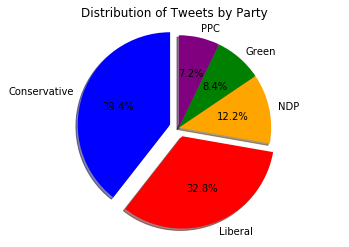

In [30]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
total_sum = df['liberal'].sum() + df['conservative'].sum() + df['ndp'].sum() + df['green'].sum() + df['ppc'].sum()


labels = 'Conservative', 'Liberal', 'NDP', 'Green', 'PPC'
sizes = [df['conservative'].sum()/total_sum, df['liberal'].sum()/total_sum, df['ndp'].sum()/total_sum, df['green'].sum()/total_sum, df['ppc'].sum()/total_sum]
explode = (0.1, 0.1, 0, 0, 0) 
colours = ['blue', 'red', 'orange', 'green', 'purple']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colours, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Distribution of Tweets by Party')

plt.show()

Here we can see the majority of the tweets are associated with the Conservative and Liberal Parties. This is in accordance with the outcome of the election where the vast majority of the tweets (from english speaking voters) went to the conservative and liberal party.

Now we will create some visualizations to see the most common words.

In [31]:
type(words_freq)

list

In [32]:
elect_words = str('')
general_words = str('')
for tweet in cleaned_tweets:
    elect_words = elect_words + ' ' + tweet

for tweet in cleaned_tweets2:
    general_words = general_words + ' ' + tweet

In [33]:
try:
    import wordcloud #If tweepy is already installed on the system
except:
    !pip install wordcloud
    


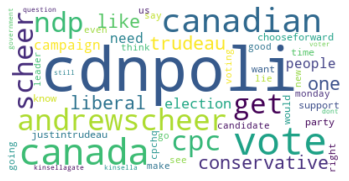

In [34]:
# Create Word Cloud for election tweets
elect_cloud = wordcloud.WordCloud(max_words=50, stopwords = stop_words, background_color="white").generate(elect_words)
plt.figure()
plt.imshow(elect_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

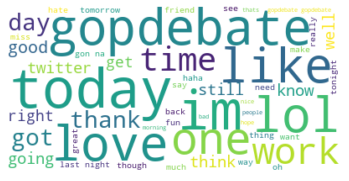

In [35]:
# Create Word Cloud for general tweets
general_cloud = wordcloud.WordCloud(max_words=50, stopwords = stop_words, background_color="white").generate(general_words)
plt.figure()
plt.imshow(general_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Model Preparation

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier 


In [37]:
# Drop rows with neautral sentiment
df2 = df2.drop(df2[df2.sentiment == 'Neutral'].index)

In [38]:
# Set this parameter false to use word frequency, true to use tf-idf
tf_idf = True

In [39]:
# Use count vectorizer to preprocess data using word frequency as features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df2.cleaned_text) 
df2.replace({'sentiment': {'Positive': 1, 'Negative': 0}}, inplace = True)
y = df2.sentiment.values
y = y.astype('int')

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer

# Use TF-IDF for features
if tf_idf:
    tf_transformer = TfidfTransformer(use_idf = True).fit(X)
    X = tf_transformer.transform(X)

In [41]:
# Split data into 70% Training Set and 30% Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# 4. Model Implementation

In [42]:
# Set up Grid Search to find best hyperparamters
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train)

10

In [43]:
# Logistic Regression

for C in [0.001, 0.01, 0.1, 1., 10.]:
    accuracy = np.zeros(10)
    i = 0
    
    for train_idx, val_idx in kfold.split(X_train):

        X_train1, X_val = X_train[train_idx], X_train[val_idx]
        y_train1, y_val = y_train[train_idx], y_train[val_idx]

        lr = LogisticRegression(C=C)
        lr.fit(X_train1, y_train1)

        accuracy[i] = lr.score(X_val, y_val)
        #print ("Fold: {}, Accuracy: {} %".format(i + 1, round(accuracy[i]*100,3)))    
        i += 1

    print("C = {}\nAverage Accuracy: {} +/- {} %".format(C, round(accuracy.mean()*100, 3), round(accuracy.std()*100,3)))

C:\Users\Sam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C = 0.001
Average Accuracy: 54.66 +/- 0.528 %
C = 0.01
Average Accuracy: 66.927 +/- 0.485 %
C = 0.1
Average Accuracy: 75.764 +/- 0.462 %
C = 1.0
Average Accuracy: 77.377 +/- 0.376 %
C = 10.0
Average Accuracy: 76.559 +/- 0.308 %


Maximum Depth = 5
Average Accuracy: 57.696 +/- 0.526 %
Maximum Depth = 10
Average Accuracy: 59.604 +/- 0.517 %
Maximum Depth = 20
Average Accuracy: 61.289 +/- 0.51 %
Maximum Depth = 50
Average Accuracy: 65.432 +/- 0.606 %
Maximum Depth = 100
Average Accuracy: 66.962 +/- 0.552 %


[Text(167.4, 181.2, 'thanks <= 0.115\nentropy = 0.994\nsamples = 82322\nvalue = [44957, 37365]\nclass = positive'),
 Text(83.7, 108.72, 'sad <= 0.058\nentropy = 0.991\nsamples = 80413\nvalue = [44647, 35766]\nclass = positive'),
 Text(41.85, 36.23999999999998, '\n  (...)  \n'),
 Text(125.55000000000001, 36.23999999999998, '\n  (...)  \n'),
 Text(251.10000000000002, 108.72, 'thanks <= 0.262\nentropy = 0.64\nsamples = 1909\nvalue = [310, 1599]\nclass = negatives'),
 Text(209.25, 36.23999999999998, '\n  (...)  \n'),
 Text(292.95, 36.23999999999998, '\n  (...)  \n')]

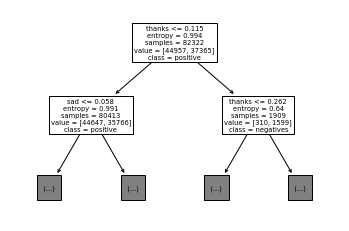

In [44]:
# Decision Tree
for n_max in [5,10,20,50,100]:
    accuracy = np.zeros(10)
    i = 0

    for train_idx, val_idx in kfold.split(X_train):

        X_train1, X_val = X_train[train_idx], X_train[val_idx]
        y_train1, y_val = y_train[train_idx], y_train[val_idx]

        clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = n_max)
        clf.fit(X_train1, y_train1.ravel())

        accuracy[i] = clf.score(X_val, y_val)
        #print ("Fold: {}, Accuracy: {} %".format(i + 1, round(accuracy[i]*100,3)))    
        i += 1

    print("Maximum Depth = {}\nAverage Accuracy: {} +/- {} %".format(n_max, round(accuracy.mean()*100, 3), round(accuracy.std()*100,3)))

# First two leafs of tree
tree.plot_tree(clf, max_depth = 1, feature_names = vectorizer.get_feature_names(), class_names = ["positive", "negatives"])

In [45]:
# Support Vector Classifier (Takes a long time to run)
svc = SVC()
svc.fit(X_train, y_train.ravel())
svc.score(X_test, y_test)

C:\Users\Sam\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5484553965460065

In [46]:
# KNN

for k in [1, 3, 5, 7, 10, 15]:
    accuracy = np.zeros(10)
    i = 0
    
    for train_idx, val_idx in kfold.split(X_train):

        X_train1, X_val = X_train[train_idx], X_train[val_idx]
        y_train1, y_val = y_train[train_idx], y_train[val_idx]

        knn = neighbors.KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train1, y_train1.ravel())

        accuracy[i] = knn.score(X_val, y_val)
        #print ("Fold: {}, Accuracy: {} %".format(i + 1, round(accuracy[i]*100,3)))    
        i += 1

    print("k = {}\nAverage Accuracy: {} +/- {} %".format(k, round(accuracy.mean()*100, 3), round(accuracy.std()*100,3)))

k = 1
Average Accuracy: 55.147 +/- 0.504 %
k = 3
Average Accuracy: 53.549 +/- 1.872 %
k = 5
Average Accuracy: 54.762 +/- 0.728 %
k = 7
Average Accuracy: 54.182 +/- 0.726 %
k = 10
Average Accuracy: 54.44 +/- 0.732 %
k = 15
Average Accuracy: 52.942 +/- 0.911 %


In [47]:
# Random Forest
for n in [5, 10, 20]:
    accuracy = np.zeros(10)
    i = 0
    
    for train_idx, val_idx in kfold.split(X_train):

        X_train1, X_val = X_train[train_idx], X_train[val_idx]
        y_train1, y_val = y_train[train_idx], y_train[val_idx]

        rfc = RandomForestClassifier(n_estimators=n)
        rfc.fit(X_train1, y_train1.ravel())

        accuracy[i] = rfc.score(X_val, y_val)
        print ("Fold: {}, Accuracy: {} %".format(i + 1, round(accuracy[i]*100,3)))    
        i += 1

    print("n_estimators = {}\nAverage Accuracy: {} +/- {} %".format(n, round(accuracy.mean()*100, 3), round(accuracy.std()*100,3)))


Fold: 1, Accuracy: 72.767 %
Fold: 2, Accuracy: 71.28 %
Fold: 3, Accuracy: 71.805 %
Fold: 4, Accuracy: 72.461 %
Fold: 5, Accuracy: 71.816 %
Fold: 6, Accuracy: 71.805 %
Fold: 7, Accuracy: 71.871 %
Fold: 8, Accuracy: 72.013 %
Fold: 9, Accuracy: 71.9 %
Fold: 10, Accuracy: 71.791 %
n_estimators = 5
Average Accuracy: 71.951 +/- 0.384 %
Fold: 1, Accuracy: 74.254 %
Fold: 2, Accuracy: 73.357 %
Fold: 3, Accuracy: 74.057 %
Fold: 4, Accuracy: 74.024 %
Fold: 5, Accuracy: 73.948 %
Fold: 6, Accuracy: 73.937 %
Fold: 7, Accuracy: 73.598 %
Fold: 8, Accuracy: 72.997 %
Fold: 9, Accuracy: 74.229 %
Fold: 10, Accuracy: 73.562 %
n_estimators = 10
Average Accuracy: 73.796 +/- 0.385 %
Fold: 1, Accuracy: 75.85 %
Fold: 2, Accuracy: 74.494 %
Fold: 3, Accuracy: 75.347 %
Fold: 4, Accuracy: 75.139 %
Fold: 5, Accuracy: 75.467 %
Fold: 6, Accuracy: 74.921 %
Fold: 7, Accuracy: 75.314 %
Fold: 8, Accuracy: 74.669 %
Fold: 9, Accuracy: 74.601 %
Fold: 10, Accuracy: 75.104 %
n_estimators = 20
Average Accuracy: 75.091 +/- 0.405

The algorithms with the best performance in terms of bias-variance tradeoff were the logistic regression and random forest models. Due to the length of time required to train the random forest on a dataset of this size, we will use the logistic regression algorithm on the election tweets.

In [48]:
# The algorithm with the best performance was the logistic regression model with C = 1.0.
# We will now prepare the elections data and apply the model.
df.replace({'sentiment': {'Positive': 1, 'Negative': 0}}, inplace = True)
vectorizer2 = CountVectorizer()
X_elect = vectorizer2.fit_transform(df.cleaned_text) 
tf_transformer2 = TfidfTransformer(use_idf = True).fit(X_elect)
X_elect = tf_transformer2.transform(X_elect)
y_elect = df.sentiment.values

In [49]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_elect, y_elect, test_size = 0.3, random_state = 42)


C:\Users\Sam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy score on the test data was: 69.688 %


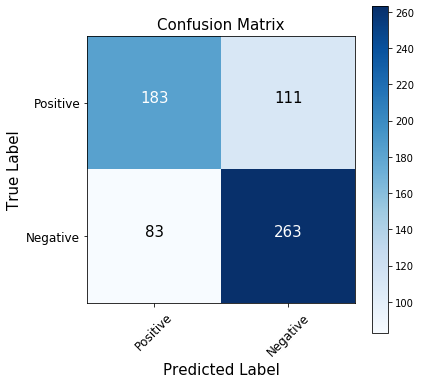

In [50]:
# Run logistic regression using C = 1
lr = LogisticRegression(C=1.0)
lr.fit(X_train, y_train)

print('The accuracy score on the test data was: {} %'.format(round(lr.score(X_test, y_test)*100, 3)))

# Plot confusion matrix
cm = confusion_matrix(y_test, lr.predict(X_test))
labell = ['Positive', 'Negative']

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(labell))
plt.xticks(tick_marks, labell, rotation=45, fontsize=12)
plt.yticks(tick_marks, labell, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 180:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Here we see that the model does not perform as well on political tweets as it does on general tweets. Let's visualize the predictions using all of the election tweets.

In [51]:
# Get predictions for all tweets
sentiment_preds = lr.predict(X_elect)
df['Predicted_Sentiment'] = sentiment_preds
df.head()

,sentiment,negative_reason,text,cleaned_text,liberal,conservative,ndp,green,ppc,Predicted_Sentiment
0,0,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...,0,1,0,0,0,0
1,1,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacestation etobicokeno...,0,0,0,0,0,1
2,0,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,1,1,0,0,0,1
3,1,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavotes cant decide help,0,0,0,0,0,1
4,0,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...,1,0,0,0,0,0


In [52]:
# Visualize sentiment for each major party (Libreral, Conservative, NDP)
# Drop rows that have two parties associated with them, sentiment will be ambiguous (~500 samples)
df = df.drop(df[(df.liberal == 1) & (df.conservative == 1)].index)
df = df.drop(df[(df.ndp == 1) & (df.conservative == 1)].index)
df = df.drop(df[(df.ndp == 1) & (df.liberal == 1)].index)




In [53]:
# Create new column for plotting
def get_party(row):
    for c in df.columns:
        if c == 'liberal' or c == 'conservative' or c == 'ndp': 
            if row[c] == 1:
                return c
df['Party'] = df.apply(get_party, axis = 1)
df.head()

,sentiment,negative_reason,text,cleaned_text,liberal,conservative,ndp,green,ppc,Predicted_Sentiment,Party
0,0,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...,0,1,0,0,0,0,conservative
1,1,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacestation etobicokeno...,0,0,0,0,0,1,None
3,1,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavotes cant decide help,0,0,0,0,0,1,None
4,0,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...,1,0,0,0,0,0,liberal
5,0,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",cdnpoli facts blastfromthepast conservatives i...,0,1,0,0,0,0,conservative


Text(0.5, 1.0, 'Actual Sentiment Distribution for Each Party')

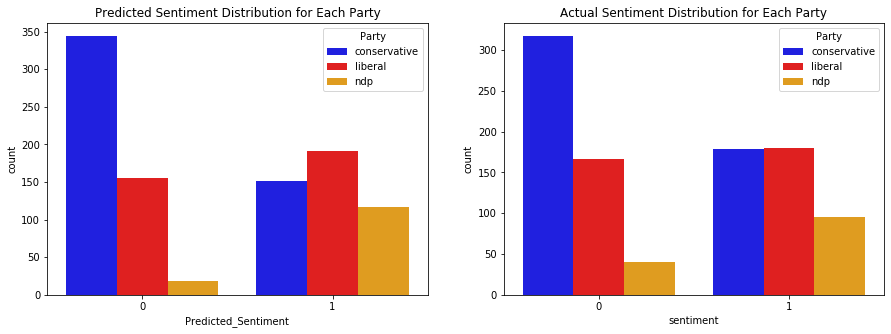

In [54]:
# Distribution of Predicted Sentiment among parties
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x = 'Predicted_Sentiment', hue = 'Party', palette = ['blue', 'red', 'orange'], data = df, ax = ax1).set_title('Predicted Sentiment Distribution for Each Party')
sns.countplot(x = 'sentiment', hue = 'Party', palette = ['blue', 'red', 'orange'], data = df, ax = ax2).set_title('Actual Sentiment Distribution for Each Party')

From the model implementation, we can see that we are able to predict the sentiment of political tweets with reasonable accuracy (~70 %). First, let's dicuss some of the insights we can extract from using natural language processing to analyze tweets. We can associate tweets with one or more political parties and use that to determine which parties are being discussed most. Using our classification algorithm, we can predict the sentiment of new tweets to some extent. Judging from the plots above, we can see that the predicted sentiment distributions approxiamtely agree with the actual sentiment. The only outlier is that the predicted sentiment overestimates the number of negative tweets regarding the conservative party. If we compare this to the outcome of the election (Liberal minority), then we could conclude that twitter analytics is at least somewhat useful in predicting elections. The conservative party is viewed much more negatively than the liberal party according to the sentiment distribution. In reality, the liberals only won a minority government by a small margin, indicating that the analysis is overestimates the party sentiment. This figure may also infer that the NDP would perform quite well since their ratio of negative to positive sentiment is the highest. In actuality, the NDP recieved significantly fewer seats than everyone expected.

There are numerous aspects of this analysis that lead us to the conclusion that natural language processing is limited in its ability to predict election outcomes from twitter data. To begin, we can see that the conservatives were tweeted about the most. As mentioned, the analysis shows that there is mostly negative sentiment toward the conservatives, but the election was actually very close. This may indicate that the majority of people tweeting about the election have progressive views to begin with. Additionally, numerous tweets are associated with multiple parties, and natural language processing is unable to assign the sentiment to one specific party in these cases.  Finally, this analysis depends on manually assigned sentiment by individuals which is averaged to a single value. The problem is that with political tweets, there are unavoidable biases that are inherent within this analysis and the assigned sentiments. In conclusion, natural language processing analysis seems to be partially indicative of party sentiment based on the election results.

In [55]:
# We can now try to classify negative tweets based on their reasoning. To do this,
# we must isolate the negative tweets and encode the reasoning as targets.
df_neg = df[df.sentiment == 0]
df_neg = df_neg.drop(['Party', 'Predicted_Sentiment', 'sentiment'], axis = 1)
df_neg.negative_reason.unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Tell lies', 'Scandal', 'Privilege', 'Healthcare',
       'Climate Problem', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

In [56]:
# Lets combine some of the negative reasons together as follows:
# Tells Lies and Scandal are both related to mistrust, but since they are already large categories we will keep separate
# Healthcare/Healthcare and Marijuana
# Drop others since these include unrelated targets
df_neg = df_neg.replace({'negative_reason':{'Healthcare and Marijuana': 'Healthcare'}})
df_neg = df_neg.drop(df_neg[df_neg.negative_reason == 'Others'].index)
df_neg.head()

,negative_reason,text,cleaned_text,liberal,conservative,ndp,green,ppc
0,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...,0,1,0,0,0
4,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...,1,0,0,0,0
15,Tell lies,"b""#LyingAndy has a history of not answering em...",lyingandy history answering embarrassing quest...,0,1,0,0,0
19,Scandal,"b""*Urgent* Please watch this video by David Ha...",urgent please watch video david haskell people...,0,1,0,0,0
26,Scandal,"b""@AlternateSpunky @ElectionsCan_E @ElectionsO...",alternatespunky electionscane electionson citi...,0,0,0,0,0


In [57]:
# Now lets prepare our features and targets using TF-IDF
vectorizer3 = CountVectorizer()
X_neg = vectorizer3.fit_transform(df_neg.cleaned_text) 
tf_transformer3 = TfidfTransformer(use_idf = True).fit(X_neg)
X_neg = tf_transformer3.transform(X_neg)

# Encode target as:
# 'Women Reproductive right and Racism' = 0
# 'Economy' = 1
# 'Tell lies' = 2
# 'Scandal' = 3
# 'Privilege' = 4
# 'Healthcare' = 5
# 'Climate Problem' = 6
# 'Separation' = 7

df_neg = df_neg.replace({'negative_reason': {'Women Reproductive right and Racism': 0,
                                'Economy': 1,
                                'Tell lies': 2,
                                'Scandal': 3,
                                'Privilege': 4,
                                'Healthcare': 5,
                                'Climate Problem': 6,
                                'Separation': 7}})

# Targets
y_neg = df_neg.negative_reason.values
y_neg.size



518

In [58]:
# Would also like to join party association as a feature
temp = pd.DataFrame(X_neg.todense())
temp['liberal'] = df_neg.liberal.values
temp['conservative'] = df_neg.conservative.values
temp['ndp'] = df_neg.ndp.values
X_neg = temp

In [59]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_neg, y_neg, test_size = 0.3, random_state = 101)

We will use logistic regression, KNN, and decision trees as our classification algorithms.

In [60]:
# Set up Grid Search to find best hyperparamters
kfold2 = KFold(n_splits=5)
kfold2.get_n_splits(X_train)

5

In [61]:
# Logistic Regression
import warnings
warnings.filterwarnings('ignore')

for C in [0.001, 0.01, 0.1, 1., 10., 100., 1000, 10000., 100000., 1000000, 10000000.]:
    accuracy = np.zeros(5)
    i = 0
    
    for train_idx, val_idx in kfold2.split(X_train):

        X_train1, X_val = pd.DataFrame(X_train.values[train_idx]), pd.DataFrame(X_train.values[val_idx])
        y_train1, y_val = y_train[train_idx], y_train[val_idx]

        lr = LogisticRegression(C=C)
        lr.fit(X_train1, y_train1)

        accuracy[i] = lr.score(X_val, y_val)
        #print ("Fold: {}, Accuracy: {} %".format(i + 1, round(accuracy[i]*100,3)))    
        i += 1

    print("C = {}\nAverage Accuracy: {} +/- {} %".format(C, round(accuracy.mean()*100, 3), round(accuracy.std()*100,3)))


C = 0.001
Average Accuracy: 42.542 +/- 1.016 %
C = 0.01
Average Accuracy: 42.542 +/- 1.016 %
C = 0.1
Average Accuracy: 41.153 +/- 3.344 %
C = 1.0
Average Accuracy: 51.655 +/- 5.563 %
C = 10.0
Average Accuracy: 56.933 +/- 6.251 %
C = 100.0
Average Accuracy: 59.981 +/- 6.225 %
C = 1000
Average Accuracy: 60.529 +/- 6.105 %
C = 10000.0
Average Accuracy: 61.358 +/- 6.135 %
C = 100000.0
Average Accuracy: 62.466 +/- 6.215 %
C = 1000000
Average Accuracy: 61.91 +/- 5.666 %
C = 10000000.0
Average Accuracy: 62.74 +/- 5.56 %


In [62]:
# KNN

for k in [1, 3, 5, 7, 10, 15, 20, 30, 50]:
    accuracy = np.zeros(5)
    i = 0
    
    for train_idx, val_idx in kfold2.split(X_train):

        X_train1, X_val = pd.DataFrame(X_train.values[train_idx]), pd.DataFrame(X_train.values[val_idx])
        y_train1, y_val = y_train[train_idx], y_train[val_idx]

        knn = neighbors.KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train1, y_train1.ravel())

        accuracy[i] = knn.score(X_val, y_val)
        #print ("Fold: {}, Accuracy: {} %".format(i + 1, round(accuracy[i]*100,3)))    
        i += 1

    print("k = {}\nAverage Accuracy: {} +/- {} %".format(k, round(accuracy.mean()*100, 3), round(accuracy.std()*100,3)))

k = 1
Average Accuracy: 49.745 +/- 6.171 %
k = 3
Average Accuracy: 58.558 +/- 4.757 %
k = 5
Average Accuracy: 54.703 +/- 3.187 %
k = 7
Average Accuracy: 56.91 +/- 4.576 %
k = 10
Average Accuracy: 57.473 +/- 5.035 %
k = 15
Average Accuracy: 55.259 +/- 4.73 %
k = 20
Average Accuracy: 54.718 +/- 5.916 %
k = 30
Average Accuracy: 53.337 +/- 5.897 %
k = 50
Average Accuracy: 47.527 +/- 4.888 %


In [63]:
# Random Forest
for n in [5, 10, 20, 50]:
    accuracy = np.zeros(5)
    i = 0
    
    for train_idx, val_idx in kfold2.split(X_train):

        X_train1, X_val = pd.DataFrame(X_train.values[train_idx]), pd.DataFrame(X_train.values[val_idx])
        y_train1, y_val = y_train[train_idx], y_train[val_idx]

        rfc = RandomForestClassifier(n_estimators=n)
        rfc.fit(X_train1, y_train1.ravel())

        accuracy[i] = rfc.score(X_val, y_val)
        #print ("Fold: {}, Accuracy: {} %".format(i + 1, round(accuracy[i]*100,3)))    
        i += 1

    print("n_estimators = {}\nAverage Accuracy: {} +/- {} %".format(n, round(accuracy.mean()*100, 3), round(accuracy.std()*100,3)))


n_estimators = 5
Average Accuracy: 53.333 +/- 5.541 %
n_estimators = 10
Average Accuracy: 58.874 +/- 7.609 %
n_estimators = 20
Average Accuracy: 56.37 +/- 5.719 %
n_estimators = 50
Average Accuracy: 58.596 +/- 5.183 %


It seems the logistic regression and random forest perform slightly better than the KNN. Lets apply the optimal hyperparamters and use the test set to visualize our accuracy.

In [64]:
# Best Hyperparameters
C = 1000000. # LogisticReg
k = 15 # KNN
n = 20 # RandForest


Logistic Regression accuracy score on the test set is: 54.487 %


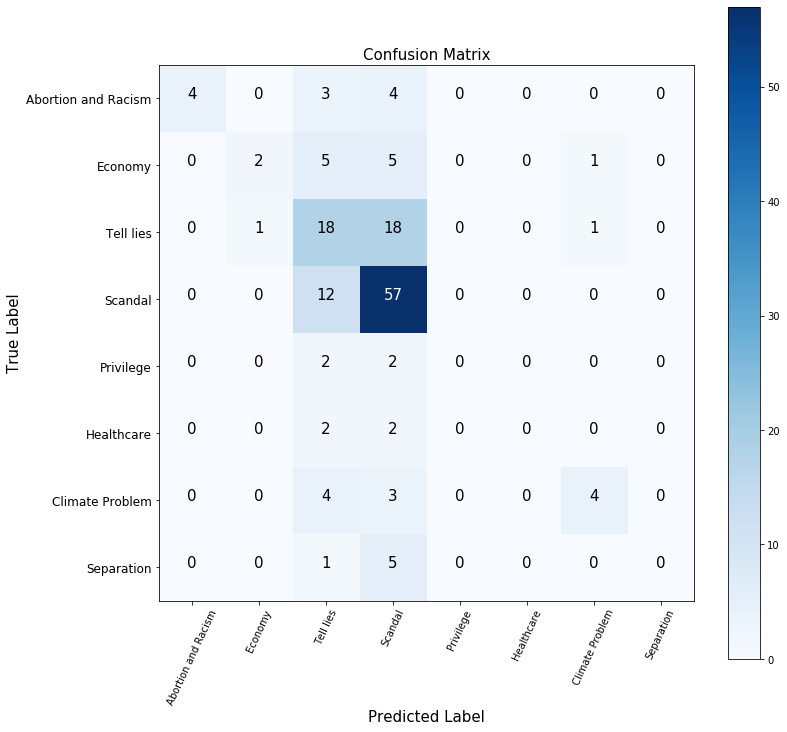

In [65]:
# Logistic Regression
lr = LogisticRegression(C=C)
lr.fit(X_train, y_train)
cm = confusion_matrix(y_test, lr.predict(X_test))
labelz = ['Abortion and Racism',
          'Economy',
          'Tell lies',
          'Scandal',
          'Privilege',
          'Healthcare',
          'Climate Problem',
          'Separation']

plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(labelz))
plt.xticks(tick_marks, labelz, rotation=65, fontsize=10)
plt.yticks(tick_marks, labelz, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 40:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
        
print('Logistic Regression accuracy score on the test set is: {} %'.format(round(lr.score(X_test, y_test)*100, 3)))

KNN accuracy score on the test set is: 48.718 %


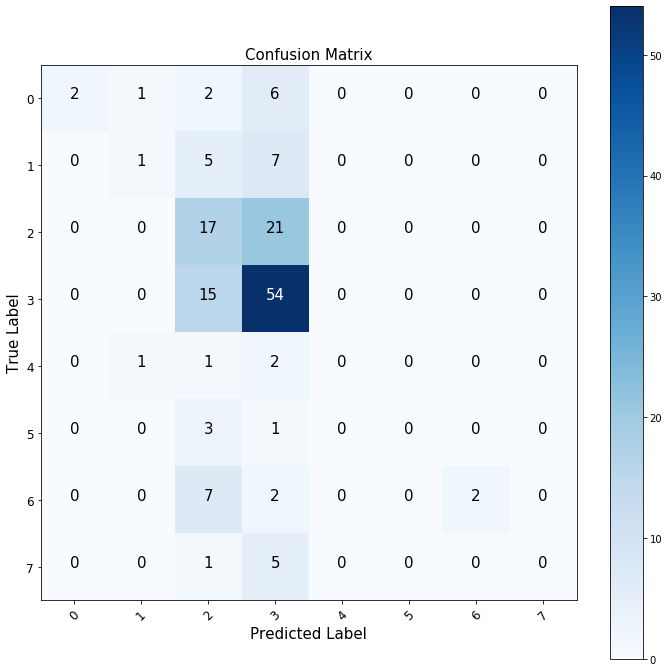

In [66]:
# KNN
knn = neighbors.KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)
cm = confusion_matrix(y_test, knn.predict(X_test))
labelz = ['Women Reproductive right and Racism',
                                'Economy',
                                'Tell lies',
                                'Scandal',
                                'Privilege',
                                'Healthcare',
                                'Climate Problem',
                                'Separation']

plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(labelz))
plt.xticks(tick_marks, labelz.sort(), rotation=45, fontsize=12)
plt.yticks(tick_marks, labelz.sort(), fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 40:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
        
print('KNN accuracy score on the test set is: {} %'.format(round(knn.score(X_test, y_test)*100, 3)))

KNN accuracy score on the test set is: 54.487 %


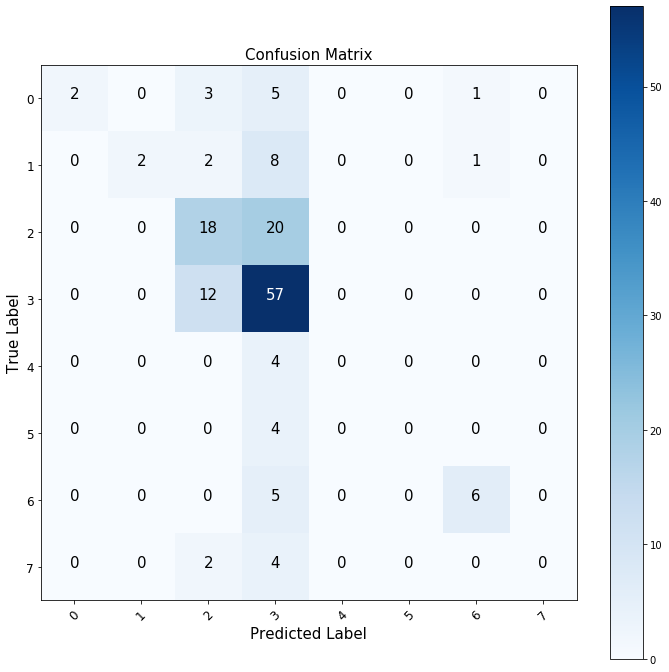

In [67]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=n)
rfc.fit(X_train, y_train)
cm = confusion_matrix(y_test, rfc.predict(X_test))
labelz = ['Women Reproductive right and Racism',
                                'Economy',
                                'Tell lies',
                                'Scandal',
                                'Privilege',
                                'Healthcare',
                                'Climate Problem',
                                'Separation']

plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(labelz))
plt.xticks(tick_marks, labelz.sort(), rotation=45, fontsize=12)
plt.yticks(tick_marks, labelz.sort(), fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 40:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
        
print('KNN accuracy score on the test set is: {} %'.format(round(rfc.score(X_test, y_test)*100, 3)))

# 5. Discussion

### What can public opinion on twitter tell us about the Canadian Political landscape in 2019?

The Twitter data analysis included data exploration, sentiment analysis, and negative reason prediction. The results allow us to make some clear conclusions about the political landscape as well as some additional hypotheses.

During data exploration, we were able to associate political parties with a number of tweets. This allowed us to visualize the distribution of tweets based on the political party. It was clear that the vast majority of the tweets (~75%) related to either the conservative or liberal party. From this fact alone, we can conclude that the winner of the election was always going to be one of these two parties, since they are the most discussed on Twitter. However, this fact is not very insightful since the Liberals or Conservatives are always the two most popular parties. In recent elections, the NDP has also been a prominent party, recieving a significant minority of the votes in 2011. In 2019, it seems that they are less mentioned (11% of tweets) than what would normally be expected. To summarize, we can clearly conclude that this election was a two party race.

The results of the sentiment analysis indicated what the popular opinion (on Twitter) of each party may be. The conservatives were associated with approximately double the amount of negative tweets than positive. The Liberals had roughly the same amount of negative and positive tweets, and the NDP had majority positive tweets. This outcome suggests that the public opinion of the conservative party may be considerably lower than the other parties. As mentioned however, the outcome of the election was a slim minority victory for the Liberals, which indicates that the conservative party may not actually be viewed so poorly. There are numerous hypotheses why the Twitter data may lead us astray in this facet. The conservatives have more bold and polarizing policies which may be more likely to recieve backlash from progressive individuals. Additionally, the demographic of people that use Twitter is quite narrow, and may be correlated with political views to some extent. In this sense, we should be careful when drawing conclusions about the entirety of the political landscape from a small sample of anonymous tweets. 

From an algoithmic perspective, the model achieves 69% accuracy on the election data test set. While this accuracy is decent, it could be improved with a larger sample size. The number of samples by the end of the data processing is ~650, which is fairly low given the number of features when using TF-IDF. To improve the model, we could obtain more tweets pertaining the 2019 election using the Twitter API and pay for them to be labelled manually. Additionally, to increase the training set size we could combine the Sentiment.csv dataset with the 2019 elections data. While the language used in the two datasets may be different, there would be some predictive value in using the general tweets alongside the election tweets.

Multinomial classification was performed on the tweets with negative sentiments to try and predict the reason for the negative tweets. The model achieved a fair accuracy of ~55% given that their were eight different classes. There are multiple potential reasons for this low accuracy in which I will name a few. There were significantly more samples with the targets 'Scandal' and 'Tell lies' then any of the other classes, indicating that this dataset was heavily imbalanced. We can see from the above confusion matrix where numerous samples have been incorrectly labelled as one of these two categories. We also notice that samples from these two categoires we misclassified with each other more than any other class, possibly because 'Scandal' and 'Tell lies' essentially relate to this concept of mistrust, and there may be overlap in the language used in the tweets. Finally, most of the classes had very few samples in them, which makes it difficult for the algorithm to predict on the test set correctly since it is unlikely that there will be overlap in the language used in a small sample size. Ways to improve this algorithm may include increasing the sample size, further consolidating the classes, and using a scoring metric that takes into account the class imbalance such as F-Score.

